V1 includes:

- For IRR: calculating future IRRs based on targets

- For MOIC: adding graph of target and value of Break even (P&I based on 10% a year)

In [9]:
import os
import sys
import pandas as pd
import datetime
import numpy as np
import warnings
warnings.filterwarnings('ignore') 
#import xlsxwriter
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [10]:
import pandas_gbq
import numpy_financial as npf

## Variable for all books

In [117]:
annual_interest_rate =0.10
factor_ak_loan=0.75

## Multitude AU Oct 21

In [19]:
###Manual:
book_id='3435712288'

In [39]:
query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)

In [41]:
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [43]:
df_purch

,book_id,actual_purchase_price,settlement_date,actual_purchase_price_usd,Region
0,3435712288,659683.0,2021-10-20,495759.97,AU


In [75]:
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,round(sum(actual_amount),2) actual_amount,round(sum(actual_amount_usd),2) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null and actual_amount is not null
order by month_cohort'''.format(book_id)

In [77]:
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [83]:
book_name=df_cf.iloc[0,1]

In [85]:
### MOIC Calculation

In [87]:
cashflow=df_cf['actual_amount'].tolist()

In [89]:
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 

In [188]:
#### Calculating Dynamic MOIC based on target

In [190]:
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 

In [99]:
####Adding Value of P&I

In [103]:
price= purchase_value.copy()

In [131]:
monthly_rate = ((1+annual_interest_rate )**(1/12))-1

In [133]:
monthly_rate

0.007974140428903764

In [149]:
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)

In [151]:
monthly_payments=monthly_payments.tolist()

In [155]:
remaining_balance = price
data = []

In [180]:
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)


In [182]:
first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]

In [184]:
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])

In [186]:
first_negative_balance_cohort_month

4

In [202]:
### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month

moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

In [204]:
moic_break_even

1.37

In [ ]:
####Calculting IRR

In [210]:
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

In [220]:
num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

In [246]:
###Adding purchase as negative number

In [252]:
fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)  

In [272]:
#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr 

In [381]:
### IRR yearly basis

irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

In [383]:
df_cf['irr_yearly']=irr_yearly 

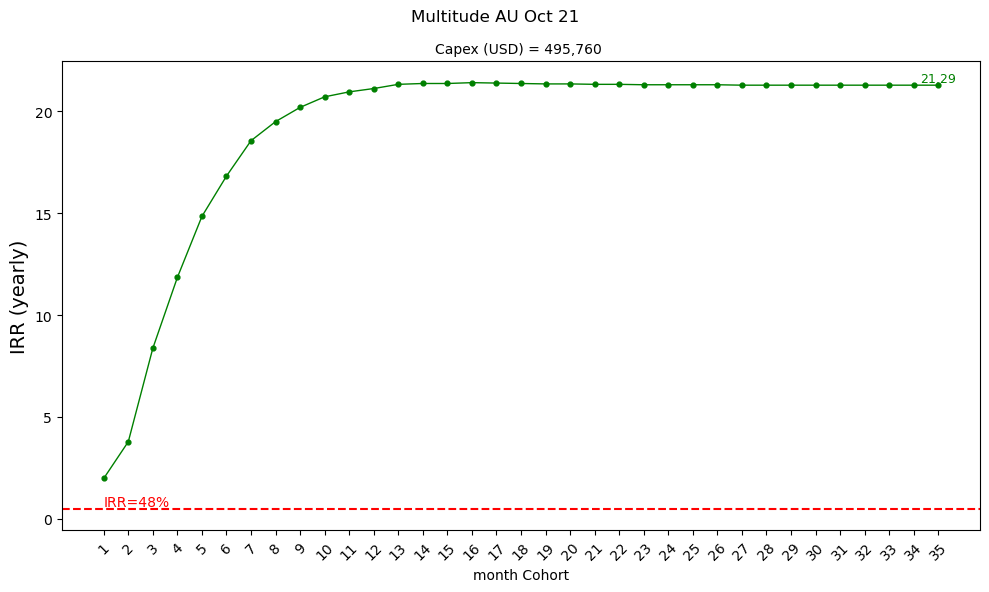

In [387]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['irr_yearly'], color='green',s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['irr_yearly'], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('IRR (yearly)',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_cf['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_cf['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_cf['irr_yearly']):
#    plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_cf['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['irr_yearly'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='red', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
#plt.text(df_cf['month_cohort'].min(), 0, '0', color='red', va='bottom', ha='center', fontsize=10)


# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48*1E-2, color='red', linestyle='--', label='y = 3.32%')
# Add a label for the y = 0 line
plt.text(df_cf['month_cohort'].min(), 48*1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

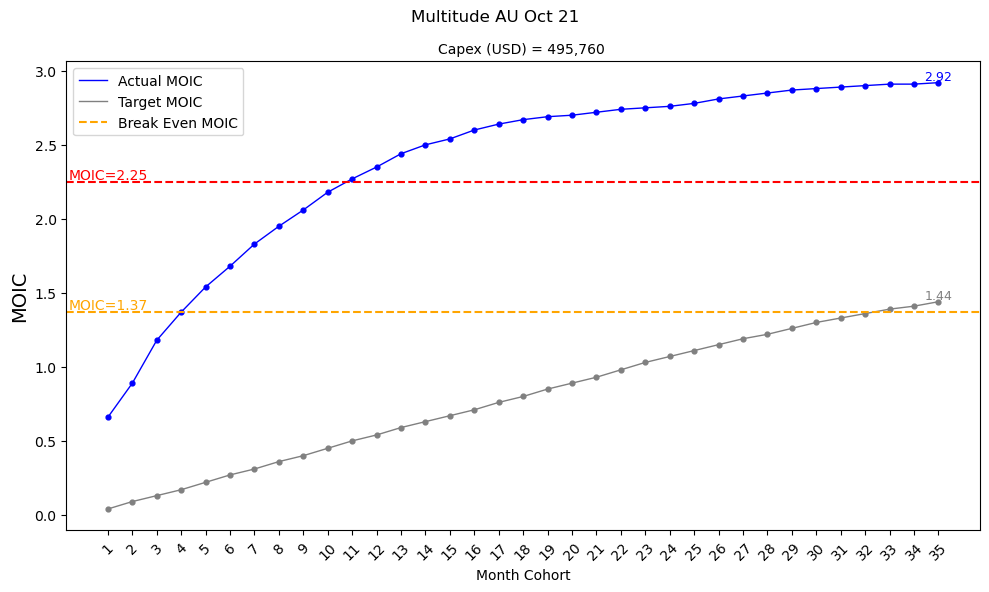

In [363]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'], df_cf['moic'], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'], df_cf['moic'], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'], df_cf['moic_target'], color='gray', s=12)
plt.plot(df_cf['month_cohort'], df_cf['moic_target'], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks
ticks = df_cf['month_cohort']
plt.xticks(ticks, rotation=45)

# Modify specific tick label to be bold or different color
#ax = plt.gca()
#for tick in ax.get_xticklabels():
#    if tick.get_text() == str(first_negative_balance_cohort_month):
#        tick.set_color('orange')  
#        tick.set_weight('bold') 



# Annotate each point with its y-value
last_x = df_cf['month_cohort'].iloc[-1]
last_y = df_cf['moic'].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Get the last value for annotation for target MOIC
last_y_target = df_cf['moic_target'].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()